# Google Play Store (Ratings)

In [2]:
from tensorflow.python.data import Dataset
from IPython import display
from sklearn import metrics
from matplotlib import pyplot as plt

import tensorflow as tf
import pandas as pd
import numpy as np

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

googleplaystore_dataframe = pd.read_csv("https://raw.githubusercontent.com/arthurflor/courses/master/google-machine-learning-crash-course/googleplaystore_pre_process.csv", sep=",")
googleplaystore_dataframe = googleplaystore_dataframe.reindex(np.random.permutation(googleplaystore_dataframe.index))
googleplaystore_dataframe["install"] /= 100
googleplaystore_dataframe

,app,category,rating,review,size,install,type,price,content_rating,genre,last_uptaded,current_ver,android_ver
3405,Nova Launcher,PERSONALIZATION,4.6,1121805,0.0,500000.0,0,0.0,Everyone,Personalization,"May 14, 2018",0.0,0.0
10621,"The FN ""Baby"" pistol explained",BOOKS_AND_REFERENCE,0.0,1,8.8,0.1,1,6.0,Everyone,Books & Reference,"September 6, 2015",Android 3.0 - 2015,1.6
9837,EU Flags Live Wallpaper,PERSONALIZATION,4.3,444,12.0,0.1,1,1.0,Everyone,Personalization,"November 18, 2013",1.95,2.1
7419,Credit Karma,FINANCE,4.7,706618,0.0,100000.0,0,0.0,Everyone,Finance,"July 31, 2018",0.0,0.0
5221,AJ Gray Icon Pack,PERSONALIZATION,4.8,5,35.0,0.5,1,1.0,Everyone,Personalization,"April 22, 2018",1.1,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,NinJump,GAME,4.3,421000,36.0,100000.0,0,0.0,Everyone,Arcade,"June 13, 2018",3.1.1,4.1
5426,Study AP World History,FAMILY,4.6,513,1.6,0.1,0,0.0,Everyone,Education,"July 18, 2016",1.1.2,4.0.3
1513,Super Funny Ringtones 2018 🔔,LIBRARIES_AND_DEMO,4.5,1703,22.0,1.0,0,0.0,Everyone,Libraries & Demo,"March 1, 2018",3.1,4.0.3
624,Speeding Joyride & Car Meet App,DATING,5.0,3,25.0,1.0,0,0.0,Mature 17,Dating,"July 20, 2018",1.2.9,4.1


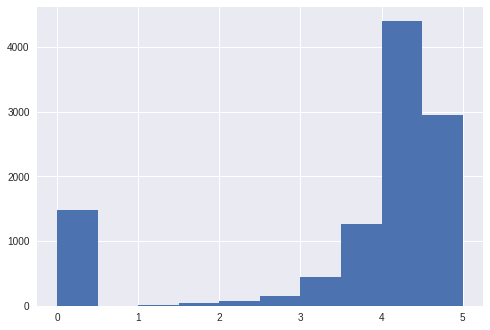

In [3]:
#googleplaystore_dataframe["rating"] = googleplaystore_dataframe["rating"].apply(lambda x: max(x, 3.2))
googleplaystore_dataframe["rating"].hist()

In [0]:
def preprocess_features(googleplaystore_dataframe):
  """Preparar inputs do dataset googleplaystore.

  Args:
    googleplaystore_dataframe: Pandas DataFrame (dataset).

  Returns:
    DataFrame contendo os inputs necessários.
  """

  selected_features = googleplaystore_dataframe[[
      "category",
      "rating",
      "review",
      "install",
      "type",
      "price",
      "content_rating",
      "genre",
   ]]

  processed_features = selected_features.copy()
  
  # Criando grupos (códigos) para as categorias
  processed_features["category"] = pd.Categorical(processed_features["category"]).codes
  processed_features["content_rating"] = pd.Categorical(processed_features["content_rating"]).codes
  processed_features["genre"] = pd.Categorical(processed_features["genre"]).codes
  
  # Criando atributo sintético.
  processed_features["rating_per_install"] = (googleplaystore_dataframe["rating"] * googleplaystore_dataframe["install"])
  return processed_features

def preprocess_targets(googleplaystore_dataframe):
  """Preparar targets do dataset googleplaystore.

  Args:
    googleplaystore_dataframe: Pandas DataFrame (dataset).

  Returns:
    DataFrame contendo os targets.
  """
  
  output_targets = pd.DataFrame()
  
  # Criando valor representando um "app de sucesso" com limiar de rating em 4 e número de reviews em 1000.
  output_targets["app_success"] = ((googleplaystore_dataframe["rating"] * googleplaystore_dataframe["install"]) > 4).astype(float)
    
  return output_targets

In [5]:
length = len(googleplaystore_dataframe)
training_len = int(length * 0.9)
validation_len = int(length * 0.1)

training_examples = preprocess_features(googleplaystore_dataframe.head(training_len))
training_targets = preprocess_targets(googleplaystore_dataframe.head(training_len))

validation_examples = preprocess_features(googleplaystore_dataframe.tail(validation_len))
validation_targets = preprocess_targets(googleplaystore_dataframe.tail(validation_len))

print("Resumo dos dados de treino (inputs):")
display.display(training_examples.describe())

print("Resumo dos dados de treino (targets):")
display.display(training_targets.describe())


print("Resumo dos dados de validação (inputs):")
display.display(validation_examples.describe())

print("Resumo dos dados de validação (targets):")
display.display(validation_targets.describe())

Resumo dos dados de treino (inputs):


,category,rating,review,install,type,price,content_rating,genre,rating_per_install
count,9720.0,9720.0,9720.0,9720.0,9720.0,9720.0,9720.0,9720.0,9720.0
mean,16.8,3.6,417213.0,147950.2,0.1,1.0,1.3,64.5,639294.1
std,8.3,1.5,2736340.4,831737.0,0.3,15.2,0.7,32.6,3557144.6
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,11.0,3.7,36.0,0.1,0.0,0.0,1.0,39.0,0.3
50%,14.0,4.2,2056.5,1.0,0.0,0.0,1.0,67.0,4.6
75%,25.0,4.5,52331.5,50000.0,0.0,0.0,1.0,96.0,195000.0
max,32.0,5.0,78158306.0,10000000.0,1.0,400.0,4.0,117.0,45000000.0


Resumo dos dados de treino (targets):


,app_success
count,9720.0
mean,0.6
std,0.5
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


Resumo dos dados de validação (inputs):


,category,rating,review,install,type,price,content_rating,genre,rating_per_install
count,1080.0,1080.0,1080.0,1080.0,1080.0,1080.0,1080.0,1080.0,1080.0
mean,16.5,3.6,702510.9,216074.7,0.1,1.3,0.2,37.7,942879.0
std,8.5,1.5,4310836.0,1013757.2,0.2,18.4,0.6,19.9,4437267.1
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,11.0,3.7,43.0,0.1,0.0,0.0,0.0,20.0,0.4
50%,14.0,4.2,2823.5,5.0,0.0,0.0,0.0,41.0,13.8
75%,24.0,4.5,71843.8,50000.0,0.0,0.0,0.0,54.0,220000.0
max,32.0,5.0,69119316.0,10000000.0,1.0,400.0,2.0,71.0,45000000.0


Resumo dos dados de validação (targets):


,app_success
count,1080.0
mean,0.6
std,0.5
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Organizar dados para treinamento.
  
    Args:
      features: pandas DataFrame (inputs)
      targets: pandas DataFrame (targets)
      batch_size: tamanho do batch para o treinamento
      shuffle: Embaralhar os dados.
      num_epochs: Número de épocas. None=indefinido
    
    Returns:
      Tupla de atributos e targets.
    """
    
    features = {index:np.array(item) for (index, item) in dict(features).items()}                                            
 
    ds = Dataset.from_tensor_slices((features, targets)) # limite de 2GB
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

In [0]:
def train_linear_classifier_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
  """Treinar modelo. Mostrar progresso de treinamento e resultados.
    
  Args:
    learning_rate: taxa de aprendizagem (float).
    steps: número de etapas do treinamento (int > 0). Consiste em uma passagem de "ida e volta" de um batch.
    batch_size: tamanho de um batch (int > 0).
    training_examples: Pandas DataFrame contendo uma ou mais colunas do dataset como atributos de input para o treinamento.
    training_targets: Pandas DataFrame contendo uma coluna com os targets (labels) para o treinamento.
    validation_examples: Pandas DataFrame contendo uma ou mais colunas do dataset como atributos de input para a validação.
    validation_targets: Pandas DataFrame contendo uma coluna com os targets (labels) para a validação.

  Returns:
    Objeto `LinearClassifier' treinado.
  """

  periods = 10
  steps_per_period = steps/periods
    
  # lambda para auxiliar na construção dos atributos em colunas para o TensorFlow
  construct_feature_columns = lambda input_features: set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])
  
  # otimizador
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  
  # classificador linear
  linear_classifier = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
  
  # lambdas para a organização dos inputs
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["app_success"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["app_success"], num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["app_success"], num_epochs=1, shuffle=False)
  
  print("Treinando...")  
  training_log_losses = []
  validation_log_losses = []
  
  for period in range(0, periods):
    # treinamento `training_input_fn`
    linear_classifier.train(input_fn=training_input_fn, steps=steps_per_period)
    
    # calcular previsões `predict_training_input_fn` (treinamento)
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    # calcular previsões `predict_validation_input_fn` (validação)
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # calculando log_loss do treinamento e validação
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    
    print("period %s | loss %0.4f | val_loss %0.4f" % ((period+1), training_log_loss, validation_log_loss))
    
    # adicionar as métricas desse período nas listas
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)

  print("Treinamento finalizado.\n")
  
  # calculando acurácia e plotando curva ROC dos dados de validação
  evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
  
  # calculando previsões `predict_validation_input_fn` (validação)
  validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
  
  # probabilidade (verdadeiro positivo e falso positivo)
  validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])
  false_positive_rate, true_positive_rate, _ = metrics.roc_curve(validation_targets, validation_probabilities)
  
  print("AUC dos dados de validação: %0.4f" % evaluation_metrics['auc'])
  print("Acurácia dos dados de validação: %0.4f\n" % evaluation_metrics['accuracy'])

  plt.figure(0)
  plt.title("AUC")
  plt.plot(false_positive_rate, true_positive_rate, label="our model")
  plt.plot([0, 1], [0, 1], label="random classifier")
  plt.legend()
  
  # plot de gráfico da métrica: log_loss vs períodos.
  plt.figure(1)
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()
  
  return linear_classifier

Treinando...
period 1 | loss 0.3422 | val_loss 0.3423
period 2 | loss 0.3181 | val_loss 0.3283
period 3 | loss 0.3014 | val_loss 0.3131
period 4 | loss 0.2934 | val_loss 0.3065
period 5 | loss 0.2886 | val_loss 0.3018
period 6 | loss 0.2805 | val_loss 0.2937
period 7 | loss 0.2775 | val_loss 0.2898
period 8 | loss 0.2757 | val_loss 0.2866
period 9 | loss 0.2782 | val_loss 0.2891
period 10 | loss 0.2781 | val_loss 0.2854
Treinamento finalizado.

AUC dos dados de validação: 0.9389
Acurácia dos dados de validação: 0.9046



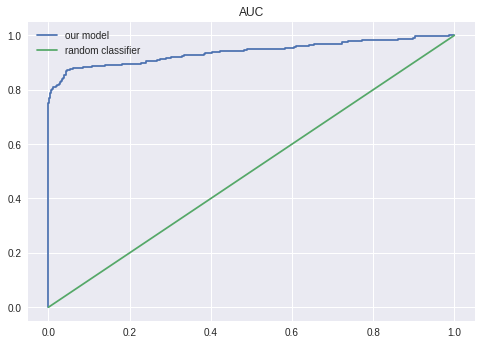

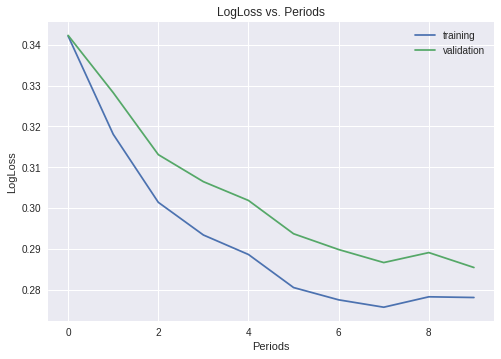

In [12]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.00003,
    steps=1000,
    batch_size=200,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)